In [18]:
import rmm

rmm.reinitialize(pool_allocator=True, initial_pool_size="8GB")

In [19]:
%load_ext cudf.pandas

import pandas as pd

data = pd.read_csv(
        "2023_Yellow_Taxi_Trip_Data_20260121_5m.csv"
)

data.tail()

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999995,2,10/29/2023 12:50:18 PM,10/29/2023 12:57:37 PM,4,1.32,1,N,161,142,1,9.3,0.0,0.5,2.66,0.0,1.0,15.96,2.5,0.0
4999996,2,05/05/2023 08:26:38 PM,05/05/2023 08:26:46 PM,1,0,5,N,161,161,1,14.3,0.0,0.0,0.00,0.0,1.0,17.8,2.5,0.0
4999997,2,02/05/2023 10:16:48 AM,02/05/2023 10:34:13 AM,1,4.3,1,N,87,48,2,22.6,0.0,0.5,0.00,0.0,1.0,26.6,2.5,0.0
4999998,2,01/14/2023 09:16:13 PM,01/14/2023 09:32:16 PM,1,2.79,1,N,48,79,1,16.3,1.0,0.5,4.26,0.0,1.0,25.56,2.5,0.0
4999999,2,11/07/2023 09:12:16 PM,11/07/2023 09:28:34 PM,1,2.5,1,N,186,211,1,16.3,1.0,0.5,4.26,0.0,1.0,25.56,2.5,0.0


In [22]:
#missing values
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

In [21]:
#clean data, replace nan and missing values
#fill w/ 0's, too many rows to drop and null or missing values most likely means 0 fee
data["airport_fee"] = data["airport_fee"].fillna(0)
data["congestion_surcharge"] = data["congestion_surcharge"].fillna(0)
#fill w/ 1, per avg
data["passenger_count"] = data["passenger_count"].fillna(1)
#fill w/ 99 per dataset info on NYC website
data["RatecodeID"] = data["RatecodeID"].fillna(99)
#drop uncessary columns
data = data.drop(columns=["store_and_fwd_flag"])

In [4]:
#find avg of column to replace missing values
data["passenger_count"].mean()

np.float64(1.3696025080037053)

In [23]:
#change fields to ints, dates, etc.
import numpy as np

# --- 1) Parse datetimes (object -> datetime) ---
for col in ["tpep_pickup_datetime", "tpep_dropoff_datetime"]:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors="coerce")

# Optional: create useful numeric time features for ML
if "tpep_pickup_datetime" in data.columns:
    data["pickup_hour"] = data["tpep_pickup_datetime"].dt.hour
    data["pickup_dow"]  = data["tpep_pickup_datetime"].dt.dayofweek

if "tpep_dropoff_datetime" in data.columns and "tpep_pickup_datetime" in data.columns:
    data["trip_minutes"] = (
        (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"])
        .dt.total_seconds() / 60
    )

# Drop raw datetime cols before XGBoost (it can’t take datetimes directly)
data = data.drop(columns=[c for c in ["tpep_pickup_datetime", "tpep_dropoff_datetime"] if c in data.columns])

# --- 2) Fix numeric columns that may be objects (commas, blanks, etc.) ---
num_cols = [
    "trip_distance", "fare_amount", "total_amount",
    "tolls_amount", "tip_amount", "extra", "mta_tax",
    "improvement_surcharge", "airport_fee", "congestion_surcharge"
]

for col in [c for c in num_cols if c in data.columns]:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace(",", "", regex=False)    # handles "62,359.52"
        .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    )
    data[col] = pd.to_numeric(data[col], errors="coerce")

# --- 3) Your missing-value rules ---
# fees/surcharges: missing likely means 0
for col in ["airport_fee", "congestion_surcharge", "tolls_amount", "tip_amount", "extra",
            "mta_tax", "improvement_surcharge"]:
    if col in data.columns:
        data[col] = data[col].fillna(0)

# passenger_count: fill with 1
if "passenger_count" in data.columns:
    data["passenger_count"] = pd.to_numeric(data["passenger_count"], errors="coerce").fillna(1).astype(int)

# RatecodeID: fill with 99
if "RatecodeID" in data.columns:
    data["RatecodeID"] = pd.to_numeric(data["RatecodeID"], errors="coerce").fillna(99).astype(int)

# store_and_fwd_flag: drop
if "store_and_fwd_flag" in data.columns:
    data = data.drop(columns=["store_and_fwd_flag"])

# Optional: handle remaining NaNs in numeric cols (XGBoost can handle NaN, but if you want)
# data = data.fillna(0)

# Quick check: what’s still non-numeric?
bad_cols = data.columns[data.dtypes == "object"].tolist()
print("Still object columns:", bad_cols[:50], "count:", len(bad_cols))

/home/joed/anaconda3/envs/xgb_env/lib/python3.13/site-packages/cudf/pandas/fast_slow_proxy.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return fn(*args, **kwargs)
/home/joed/anaconda3/envs/xgb_env/lib/python3.13/site-packages/cudf/pandas/fast_slow_proxy.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return fn(*args, **kwargs)


Still object columns: [] count: 0


In [35]:
#split data into train/test samples, and shuffle data; frac=1 is 100%;  
data = data.sample(frac=1, random_state=432).reset_index(drop=True)

In [36]:
targets = data["tip_amount"]
features = data.drop(columns=["tip_amount"])

x_train, x_test = features.iloc[:-1000000], features.iloc[-1000000:]
y_train, y_test = targets.iloc[:-1000000], targets.iloc[-1000000:]

len(x_test), len(y_test), len(x_train), len(y_train)

(1000000, 1000000, 3638448, 3638448)

In [37]:
#load xgboost model
from xgboost import XGBRegressor

model = XGBRegressor(device="cuda")

#training
model.fit(x_train, y_train)
predictions = model.predict(x_test)

predictions

array([ 2.6992943,  3.3169627, 15.6718025, ...,  3.6293786, 17.075176 ,
        3.0995004], shape=(1000000,), dtype=float32)

In [38]:
#MSE Evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

0.756646745641964

In [32]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.571281
PULocationID,1.00,265.00,164.934526
RatecodeID,1.00,99.00,4.305783
VendorID,1.00,6.00,1.747290
airport_fee,0.00,1.75,0.145259
congestion_surcharge,0.00,2.50,2.258144
extra,0.00,96.38,1.603621
fare_amount,0.00,768.10,20.330626
improvement_surcharge,0.00,1.00,0.999552
mta_tax,0.00,53.16,0.496977


In [29]:
data = data[data["trip_distance"] > 0.5]
data = data[data["trip_distance"] < 100]

data = data[~data.select_dtypes("number").lt(0).any(axis=1)]

In [31]:
data = data[data["total_amount"] > 3.7]
data = data[data["total_amount"] < 1000]

In [33]:
len(data)

4638448

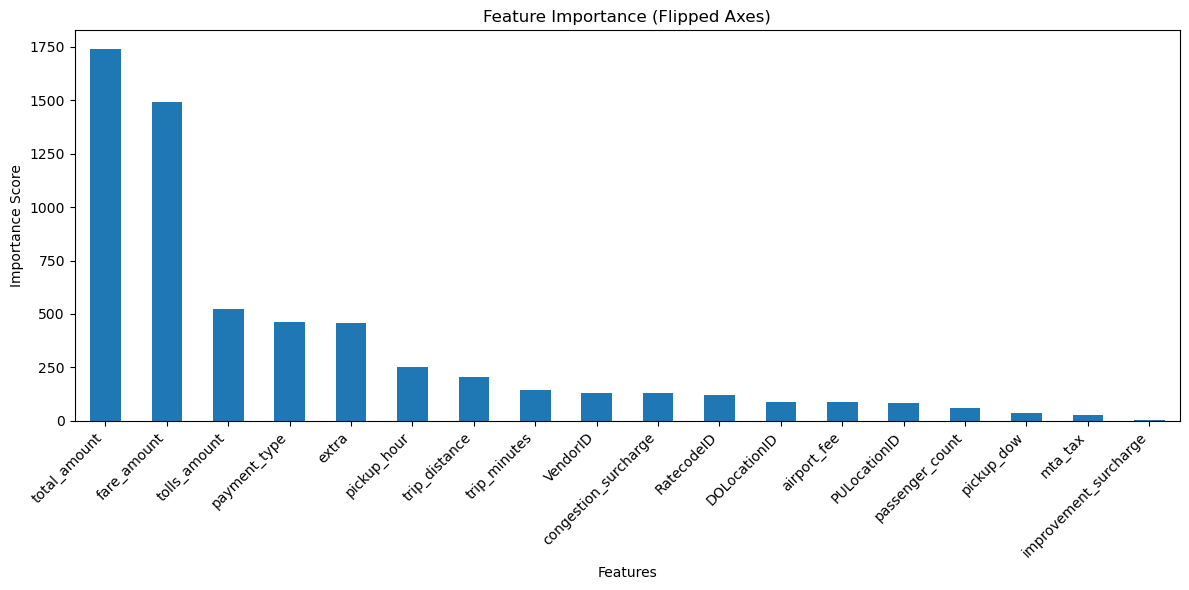

In [43]:
import matplotlib.pyplot as plt

booster = model.get_booster()
importance = booster.get_score(importance_type='weight')

#convert to dataframe
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

#sort by importance
importance_df = importance_df.sort_values(
    by='Importance',
    ascending=False
)

ax = importance_df.head(50).plot(
    kind='bar',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(12,6)
)

plt.title('Feature Importance (Flipped Axes)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



